In [1]:
# 27/02/2022 Luís

# A first draft for a multioutput ML model: This model has two branches, one outputs
# a curve for a uniaxial load and the other two curves, for a equibiaxial load.

# I'm not sure if this is the best way to have the equibiaxial branch, I thought about another possibility: 
# having three branches: uniaxial; equibiaxial yy; equibiaxial xx.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [4]:
from keras.utils.vis_utils import plot_model

In [5]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [6]:
def double_dot(A,B):
    # Double-dot operation between two 3x3 matrices
    sum = 0
    for i in range(3):
        for j in range(3):
                sum = sum + A[i,j] * B[i,j]
    return sum


def theta_to_a01(theta):
    #defines a unit vector in the xy plane, theta degrees from the yy axis
    return [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]


def HGO(params, stretch, load):
    #params = [c, κ, k1, k2, theta]
    #returns cauchy stress at yy direction if load == "uniaxial"
    #returns cauchy stress at xx and yy directions if load == "equibiaxial"
    
    if load != 'uniaxial' and load != 'equibiaxial':
        raise ValueError("Load string isn't acceptable")
    
    #3x3 Identity Matrix
    I = sym.Matrix([[1,0,0],[0,1,0],[0,0,1]])
    
    if load == "uniaxial":
        # Deformation Gradient assuming incompressibility and a uniaxial load
        F = sym.Matrix([[1/(np.sqrt(stretch)),0,0], [0,stretch,0], [0,0,1/(np.sqrt(stretch))]])
        
    if load == "equibiaxial":
        # Deformation Gradient assuming incompressibility and a equibiaxial load
        F = sym.Matrix([[stretch,0,0], [0,stretch,0], [0,0,1/(stretch**2)]])
        
    Ft=sym.transpose(F)
    Jac=sym.det(F)
    
    # Modified Deformation Gradient
    Fm = Jac**(-1/3) * I * F
    Fmt=sym.transpose(Fm)
    
    # Modified Right Cauchy-Green Deformation Tensor with values according to F: 'Cmv'
    Cmv=Fmt*Fm

    # Symbolic Modified Right Cauchy-Green Deformation Tensor 'Cm'
    Cm11 = sym.Symbol('Cm11')
    Cm12 = sym.Symbol('Cm12')
    Cm13 = sym.Symbol('Cm13')
    Cm21 = sym.Symbol('Cm21')
    Cm22 = sym.Symbol('Cm22')
    Cm23 = sym.Symbol('Cm23')
    Cm31 = sym.Symbol('Cm31')
    Cm32 = sym.Symbol('Cm32')
    Cm33 = sym.Symbol('Cm33')
    Cm = sym.Matrix([[Cm11,Cm12,Cm13], [Cm21,Cm22,Cm23], [Cm31,Cm32,Cm33]])  
    
    # Compute the invariant im1  of the tensor Cm
    im1=sym.trace(Cm)
    
    #symbolic Neo-Hookean parameter c
    c = sym.Symbol('c')
    
    # symbolic dispersion parameter κ (0 < κ < 1/3) (the symbol is the greek letter 'kappa')
    κ = sym.Symbol('κ')
    
    # symbolic material parameters k1 and k2 (k1>0; k2>0)
    k1=sym.Symbol('k1')
    k2=sym.Symbol('k2')
    
    # Unit vector representing the direction of the fibres in the stress free configuration
    # params[4] = angle theta between the mean orientation of the fibers and the yy axis.
    a01_list = theta_to_a01(params[4])
    a01 = sym.Matrix(a01_list)
    
    # Structure Tensors H1, which depend on κ and a01
    
    if double_dot(Cmv, TensorProduct(a01,sym.transpose(a01))) > 1:   # condition to only allow tensile stress
        H1 = κ*I + (1-3*κ)*(TensorProduct(a01,sym.transpose(a01)))
    else:
        H1 = κ*I
        
    E1 = double_dot(H1,Cm) - 1
    
    #alternative: for debbugging 
    #m0 =TensorProduct(a01,sym.transpose(a01))
    #im4 = double_dot(Cm,m0) #pseudo-invariant 4. very important measure. it tells us the squared stretch of the fibers
    #E1 = im4*(1-3*κ) + κ*im1-1
    
    #Generate SEF (Strain Energy Function)
    sef= 0.5 * c * (im1 - 3) + (k1/(2*k2)) * (sym.exp(k2*E1*E1) - 1)
    
    #Second Piola Kirchoff Stresses
    S11=2*sym.diff(sef,Cm11)
    S12=2*sym.diff(sef,Cm12)
    S13=2*sym.diff(sef,Cm13)
    S21=2*sym.diff(sef,Cm21)
    S22=2*sym.diff(sef,Cm22)
    S23=2*sym.diff(sef,Cm23)
    S31=2*sym.diff(sef,Cm31)
    S32=2*sym.diff(sef,Cm32)
    S33=2*sym.diff(sef,Cm33)
    S = sym.Matrix([[S11,S12,S13], [S21,S22,S23], [S31,S32,S33]])
    
    
    T = (1/Jac)*(F*S*Ft) # cauchy stresses with no BCs
    T = T - (I*T[2,2]) # imposing of boundary conditions
    
    T=T.subs([(Cm11, Cmv[0,0]), (Cm12, Cmv[0,1]), 
                                  (Cm13, Cmv[0,2]),(Cm21, Cmv[1,0]), 
                                  (Cm22, Cmv[1,1]), (Cm23, Cmv[1,2]),
                                  (Cm31, Cmv[2,0]), (Cm32, Cmv[2,1]), 
                                  (Cm33, Cmv[2,2]),(c,params[0]), 
                                  (κ,params[1]),(k1,params[2]),(k2,params[3])])
    
    if load == 'uniaxial':
        return T[1,1]

    if load == 'equibiaxial':
        return T[0,0],T[1,1]

def get_curve(params, stretch_min, stretch_max, ninc, load):
    #stores HGO loading runs between a minimum and a maximum stretch
    
    if load == "uniaxial":
        stretches=np.linspace(stretch_min,stretch_max,ninc)
        stresses=[HGO(params, stretch, load) for stretch in stretches]
        return np.asarray(stresses)
    if load == "equibiaxial":
        stretches=np.linspace(stretch_min,stretch_max,ninc)
        lst_xx=[HGO(params, stretch, load)[0] for stretch in stretches]
        lst_yy=[HGO(params, stretch, load)[1] for stretch in stretches]
        return lst_xx, lst_yy

In [7]:
#Initial data-----------------------------------------------------------------------------------------------------

c_min = 1.0
c_max = 40.0
n_c = 3

κ_min = 0.0
κ_max = 1/3
n_κ = 3

k1_min = 0.1
k1_max = 5.0
n_k1 = 3

k2_min = 0.1
k2_max = 5.0
n_k2 = 3

θ_min = 0 # in degrees
θ_max = 90 # in degrees
n_θ = 3

decimals=2   #number of decimal cases for each parameter value

n = n_c * n_κ * n_k1 * n_k2 * n_θ # total combinations

st_max=1.6            # applied stretch
st_min=1.0
ninc=20        # number of stretch increments

#parameters grid
c_list = np.round(np.random.uniform(c_min, c_max, size = n_c), decimals)
κ_list = np.round(np.random.uniform(κ_min, κ_max, size=n_κ), decimals)
k1_list = np.round(np.random.uniform(k1_min, k1_max, size=n_k1), decimals)
k2_list = np.round(np.random.uniform(k2_min, k2_max, size=n_k2), decimals)
θ_list = np.round(np.random.uniform(θ_min, θ_max, size=n_θ), decimals)

# Computes the n combinations of params

params = []

for i in c_list:
    for j in κ_list:
        for k in k1_list:
            for l in k2_list:
                for m in θ_list:
                    params.append([i,j,k,l,m])

params = np.array(params, dtype = object)
params = params.reshape(-1, 5)
np.random.shuffle(params)

# Append the combinations to a DataFrame
df = pd.DataFrame(params[:,0], columns = ['c'])
df['κ'] = params[:,1]
df['k1'] = params[:,2]
df['k2'] = params[:,3]
df['θ'] = params[:,4]

df

,c,κ,k1,k2,θ
0,27.14,0.27,4.37,0.6,24.81
1,27.28,0.27,4.37,3.11,24.81
2,27.14,0.27,4.47,0.6,65.42
3,27.28,0.32,2.45,0.6,65.42
4,27.28,0.32,4.47,0.6,3.64
5,27.28,0.32,2.45,3.11,3.64
6,27.14,0.32,4.37,0.6,3.64
7,27.28,0.27,4.47,4.07,24.81
8,27.28,0.02,2.45,4.07,3.64
9,27.28,0.02,4.47,0.6,65.42


In [8]:
#generate uniaxial
#generate (x,y) data for each unique combination of params at the dataframe, for a uniaxial load
load = "uniaxial"
df_uniaxial = df.copy()
df_uniaxial['stretch']=df.apply(lambda x : np.linspace(st_min,st_max,ninc), axis=1)
df_uniaxial['stress']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load), axis=1)

df_uniaxial

,c,κ,k1,k2,θ,stretch,stress
0,27.14,0.27,4.37,0.6,24.81,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.58846515301324, 5.19166247975635, 7.8155..."
1,27.28,0.27,4.37,3.11,24.81,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.60173656604768, 5.21827185897007, 7.8557..."
2,27.14,0.27,4.47,0.6,65.42,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.52776527240016, 5.06134988959391, 7.6060..."
3,27.28,0.32,2.45,0.6,65.42,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.57944406854333, 5.16449330990966, 7.7601..."
4,27.28,0.32,4.47,0.6,3.64,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.58752194549400, 5.18368155154389, 7.7943..."
5,27.28,0.32,2.45,3.11,3.64,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.58649702366706, 5.17989776823447, 7.7853..."
6,27.14,0.32,4.37,0.6,3.64,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.57420377317234, 5.15693469980323, 7.7539..."
7,27.28,0.27,4.47,4.07,24.81,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.60211530293442, 5.21927458047086, 7.8576..."
8,27.28,0.02,2.45,4.07,3.64,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.88307453562719, 5.84980095145995, 8.9573..."
9,27.28,0.02,4.47,0.6,65.42,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.55819283376365, 5.12115460690545, 7.6931..."


In [9]:
#generate equibiaxial

load = "equibiaxial"

df_equibiaxial = df.copy()

df_equibiaxial['stretch']=df.apply(lambda x : np.linspace(st_min,st_max,ninc), axis=1)

df_equibiaxial['stress_xx'] = np.zeros(n).tolist
df_equibiaxial['stress_yy'] = np.zeros(n).tolist

df_equibiaxial['stress']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load), axis=1)

for i in range(n): df_equibiaxial['stress_xx'][i] = df_equibiaxial['stress'][i][0]
for i in range(n): df_equibiaxial['stress_yy'][i] = df_equibiaxial['stress'][i][1]
df_equibiaxial = df_equibiaxial.drop('stress',axis = 1)

df_equibiaxial

,c,κ,k1,k2,θ,stretch,stress_xx,stress_yy
0,27.14,0.27,4.37,0.6,24.81,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 4.92619743827338, 9.47531293382311, 13.726...","[0, 4.94366953252214, 9.51968172040237, 13.807..."
1,27.28,0.27,4.37,3.11,24.81,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 4.95155737164669, 9.52411447383788, 13.797...","[0, 4.96903968046092, 9.56863153368194, 13.879..."
2,27.14,0.27,4.47,0.6,65.42,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 4.94441132646713, 9.52187128436827, 13.812...","[0, 4.92637127743257, 9.47606022851554, 13.728..."
3,27.28,0.32,2.45,0.6,65.42,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 4.94311236971473, 9.49588484465284, 13.737...","[0, 4.94226605812247, 9.49312015213425, 13.731..."
4,27.28,0.32,4.47,0.6,3.64,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 4.94350431330020, 9.50099481599307, 13.754...","[0, 4.94584645273857, 9.50864601141799, 13.770..."
5,27.28,0.32,2.45,3.11,3.64,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 4.94204752320018, 9.49241521672815, 13.730...","[0, 4.94333137020860, 9.49661265826123, 13.738..."
6,27.14,0.32,4.37,0.6,3.64,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 4.91807884215166, 9.45190838220718, 13.682...","[0, 4.92036858473459, 9.45938840994921, 13.698..."
7,27.28,0.27,4.47,4.07,24.81,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 4.95181800823693, 9.52513348113007, 13.800...","[0, 4.96970436766490, 9.57072737970854, 13.884..."
8,27.28,0.02,2.45,4.07,3.64,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 4.94258456326937, 9.48921222866439, 13.715...","[0, 5.24131837119647, 10.1669315402365, 14.907..."
9,27.28,0.02,4.47,0.6,65.42,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 5.39089805443651, 10.4675650824107, 15.320...","[0, 5.03611511104251, 9.69431538581289, 14.052..."


In [10]:
#get number of samples
nsamples=df_uniaxial.shape[0]
#get data channels. in this case, stretch and stress
channels = ['stretch','stress']
#number of channels
nchannels=len(channels)
#number of data points
npts=ninc
# data array
y_uni=np.empty((nsamples,npts,nchannels))

for idx,signal in enumerate(channels):
    #convert signal to numpy
    s=df_uniaxial[signal].to_numpy()
    #flatten
    s=np.concatenate(s)
    #flatten then reshape ()
    s=s.reshape(df_uniaxial[signal].shape[0],npts)
    #append to data array
    y_uni[:,:,idx] = s

#working with X like this will be easier to handle tensor shapes during model training 
#X = np.asarray(X).astype('float32')
#X=np.asarray(X.tolist())
print(nsamples,npts,nchannels)
#len(channels)

243 20 2


In [11]:
#get number of samples
nsamples=df_uniaxial.shape[0]
#get data channels. in this case, stretch and stress
channels = ['stretch','stress_xx','stress_yy']
#number of channels
nchannels=len(channels)
#number of data points
npts=ninc
# data array
y_bi=np.empty((nsamples,npts,nchannels))

for idx,signal in enumerate(channels):
    #convert signal to numpy
    s=df_equibiaxial[signal].to_numpy()
    #flatten
    s=np.concatenate(s)
    #flatten then reshape ()
    s=s.reshape(df_equibiaxial[signal].shape[0],npts)
    #append to data array
    y_bi[:,:,idx] = s

#working with X like this will be easier to handle tensor shapes during model training 
#X = np.asarray(X).astype('float32')
#X=np.asarray(X.tolist())
print(nsamples,npts,nchannels)
#len(channels)

243 20 3


In [12]:
#features, i.e., material parameters
#features
features = ['c','κ','k1','k2','θ'] #I won't include "a0" because it will be replaced by an angle. add that later
nfeatures=len(features)
# features array
X=np.empty((nsamples,nfeatures))

for idx,signal in enumerate(features):
    #convert signal to numpy
    s=df_uniaxial[signal].to_numpy()
    #append to features array
    X[:,idx] = s #double check if it has the correct shape
#y=df1.ehertz.to_numpy()
#y=np.asarray(y.tolist())

#export X and y to approriate files.

In [13]:
X[0]

array([27.14,  0.27,  4.37,  0.6 , 24.81])

In [14]:
y_uni[0]

array([[ 1.        ,  0.        ],
       [ 1.03157895,  2.58846515],
       [ 1.06315789,  5.19166248],
       [ 1.09473684,  7.8155915 ],
       [ 1.12631579, 10.46576976],
       [ 1.15789474, 13.14732692],
       [ 1.18947368, 15.86508999],
       [ 1.22105263, 18.62366247],
       [ 1.25263158, 21.42749978],
       [ 1.28421053, 24.28098305],
       [ 1.31578947, 27.18849329],
       [ 1.34736842, 30.1544879 ],
       [ 1.37894737, 33.18358147],
       [ 1.41052632, 36.28063312],
       [ 1.44210526, 39.4508427 ],
       [ 1.47368421, 42.69985876],
       [ 1.50526316, 46.03390151],
       [ 1.53684211, 49.45990457],
       [ 1.56842105, 52.98568057],
       [ 1.6       , 56.62011596]])

In [15]:
y_bi[0]

array([[ 1.        ,  0.        ,  0.        ],
       [ 1.03157895,  4.92619744,  4.94366953],
       [ 1.06315789,  9.47531293,  9.51968172],
       [ 1.09473684, 13.72659569, 13.8078262 ],
       [ 1.12631579, 17.74419966, 17.87295194],
       [ 1.15789474, 21.58075462, 21.76858772],
       [ 1.18947368, 25.28011048, 25.53974407],
       [ 1.22105263, 28.87948594, 29.2251302 ],
       [ 1.25263158, 32.41119105, 32.85895949],
       [ 1.28421053, 35.90405305, 36.4724777 ],
       [ 1.31578947, 39.38464684, 40.09532259],
       [ 1.34736842, 42.87841527, 43.75680894],
       [ 1.37894737, 46.41075522, 47.48722745],
       [ 1.41052632, 50.00814446, 51.3192486 ],
       [ 1.44210526, 53.69938974, 55.28953456],
       [ 1.47368421, 57.5170906 , 59.44068388],
       [ 1.50526316, 61.49943724, 63.82366969],
       [ 1.53684211, 65.69249774, 68.50098549],
       [ 1.56842105, 70.15320557, 73.5507919 ],
       [ 1.6       , 74.95334012, 79.07247399]])

In [16]:
#y = np.append(y_uni,y_bi,axis = 2)

In [17]:
#np.save('X_run', X)
#np.save('y_uni_run', y_uni)
#np.save('y_bi_run', y_bi)

Here we transition from one script to the other

In [18]:
#X = np.load('X_run.npy')
#y_uni = np.load('y_uni_run.npy')
#y_bi = np.load('y_bi_run.npy')

In [19]:
#the code below should be in a separate file. it's is important to keep data generator separated from model training

#training script should start by loading X and y

#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1

#x_train, x_test,y_train,y_test = train_test_split(X, y, test_size = test_split)

x_train, x_test,y_uni_train,y_uni_test = train_test_split(X, y_uni, test_size = test_split)
x_train, x_test,y_bi_train,y_bi_test = train_test_split(X, y_bi, test_size = test_split)


#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
#print('Training set: ',y_train.shape)
#print('Test set: ',y_test.shape)
print('Uniaxial training set: ',y_uni_train.shape)
print('Uniaxial test set: ',y_uni_test.shape)
print(' ')
print('Equibiaxial training set: ',y_bi_train.shape)
print('Equibiaxial test set: ',y_bi_test.shape)
#train_size = train_df.shape[0]
#test_size = test_df.shape[0]

#reshape for keras training
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 2))
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 2))
#shuffle data
idx = np.random.permutation(len(x_train))
#x_train = x_train[idx]
#y_train = y_uni_train[idx]

y_uni_train = y_uni_train[idx]
y_bi_train = y_bi_train[idx]


Input data
Training set:  (218, 5)
Test set:  (25, 5)
 
Features
Uniaxial training set:  (218, 20, 2)
Uniaxial test set:  (25, 20, 2)
 
Equibiaxial training set:  (218, 20, 3)
Equibiaxial test set:  (25, 20, 3)


In [80]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-1
BATCH_SIZE = 64
EPOCHS = 100
INPUT_SHAPE = x_train.shape[1:]

inputs = keras.Input(shape=INPUT_SHAPE)

In [81]:
def make_default_hidden_layers(inputs):
    dense = layers.Dense(16 * ninc, activation="relu")
    x = dense(inputs)

  #  dense = layers.Dense(32 * ninc, activation="relu")
  #  x = dense(x)
    
    dropout = tf.keras.layers.Dropout(0.2)
    x = dropout(x)

    x = tf.keras.layers.Reshape((ninc, -1))(x)

   # x = layers.Dense(32, activation="relu")(x)
    
    x = layers.Dense(16, activation="relu")(x)

    dropout = tf.keras.layers.Dropout(0.2)
    x = dropout(x)
    
    return(x)

def build_uniaxial_branch(inputs):   
    x = make_default_hidden_layers(inputs)
    x = layers.Dense(2)(x)
    x = layers.Activation("linear", name="uniaxial")(x)
    return x
    
def build_equibiaxial_branch(inputs):   
    x = make_default_hidden_layers(inputs)
    x = layers.Dense(3)(x)
    x = layers.Activation("linear", name="equibiaxial")(x)
    return x


def assemble_full_model(input_shape):
    
    inputs = keras.Input(shape=input_shape)
    
    uniaxial_branch = build_uniaxial_branch(inputs)
    equibiaxial_branch = build_equibiaxial_branch(inputs)
    
    model = keras.Model(inputs=inputs,
                     outputs = [uniaxial_branch, equibiaxial_branch],
                     name="model")
    
    return model

In [82]:
model = assemble_full_model(INPUT_SHAPE)

# Maybe I need to think better on the loss function

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["mean_squared_error"],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 160)          960         input_14[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 160)          960         input_14[0][0]                   
__________________________________________________________________________________________________
dropout_24 (Dropout)            (None, 160)          0           dense_40[0][0]                   
______________________________________________________________________________________________

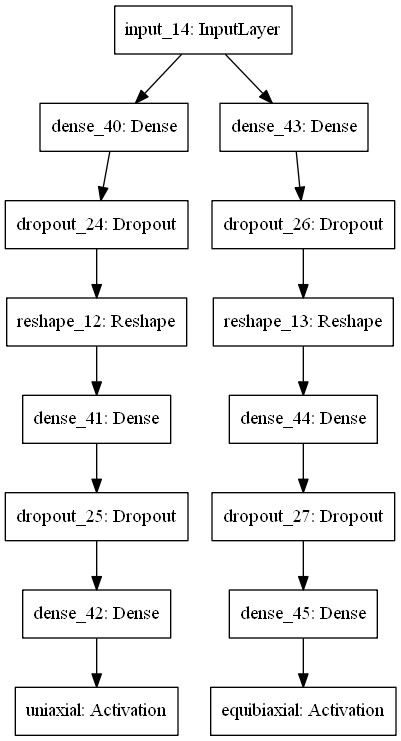

In [83]:
tf.keras.utils.plot_model(model)

In [84]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    [y_uni_train, y_bi_train],
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

test_loss_acc = model.evaluate(x_test, [y_uni_test,y_bi_test])

print("Test accuracy", test_loss_acc)

Epoch 1/100
3/3 [==============================] - 1s 183ms/step - loss: 222732096.0000 - uniaxial_loss: 42789028.0000 - equibiaxial_loss: 179943072.0000 - uniaxial_mean_squared_error: 42789028.0000 - equibiaxial_mean_squared_error: 179943088.0000 - val_loss: 159493760.0000 - val_uniaxial_loss: 40556840.0000 - val_equibiaxial_loss: 118936928.0000 - val_uniaxial_mean_squared_error: 40556840.0000 - val_equibiaxial_mean_squared_error: 118936928.0000
Epoch 2/100
3/3 [==============================] - 0s 31ms/step - loss: 222379584.0000 - uniaxial_loss: 42742844.0000 - equibiaxial_loss: 179636736.0000 - uniaxial_mean_squared_error: 42742844.0000 - equibiaxial_mean_squared_error: 179636752.0000 - val_loss: 158898656.0000 - val_uniaxial_loss: 40479828.0000 - val_equibiaxial_loss: 118418824.0000 - val_uniaxial_mean_squared_error: 40479828.0000 - val_equibiaxial_mean_squared_error: 118418824.0000
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 221149328.0000 - uniaxial_l

3/3 [==============================] - 0s 25ms/step - loss: 206308080.0000 - uniaxial_loss: 40825628.0000 - equibiaxial_loss: 165482448.0000 - uniaxial_mean_squared_error: 40825628.0000 - equibiaxial_mean_squared_error: 165482448.0000 - val_loss: 148012800.0000 - val_uniaxial_loss: 39589548.0000 - val_equibiaxial_loss: 108423248.0000 - val_uniaxial_mean_squared_error: 39589548.0000 - val_equibiaxial_mean_squared_error: 108423248.0000
Epoch 20/100
3/3 [==============================] - 0s 31ms/step - loss: 205842336.0000 - uniaxial_loss: 41435276.0000 - equibiaxial_loss: 164407056.0000 - uniaxial_mean_squared_error: 41435276.0000 - equibiaxial_mean_squared_error: 164407040.0000 - val_loss: 147560272.0000 - val_uniaxial_loss: 39584948.0000 - val_equibiaxial_loss: 107975320.0000 - val_uniaxial_mean_squared_error: 39584948.0000 - val_equibiaxial_mean_squared_error: 107975320.0000
Epoch 21/100
3/3 [==============================] - 0s 32ms/step - loss: 207694432.0000 - uniaxial_loss: 401533

1/1 [==============================] - 0s 37ms/step - loss: 148223168.0000 - uniaxial_loss: 14427884.0000 - equibiaxial_loss: 133795288.0000 - uniaxial_mean_squared_error: 14427884.0000 - equibiaxial_mean_squared_error: 133795288.0000
Test accuracy [148223168.0, 14427884.0, 133795288.0, 14427884.0, 133795288.0]


76137072.0


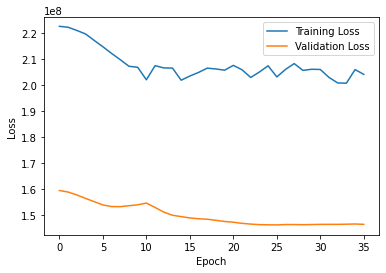

In [85]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [86]:
model.predict(x_test[0:1])[0][0]

array([[1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.4019042e+00, 7.3205551e+01],
       [1.3274715e+00, 4.5518356e+01],
       [1.1996111e+00, 3.0420322e+02],
       [1.6086365e+00, 8.2102734e+02],
       [2.7053943e+00, 1.7641902e+03],
       [8.3193741e+00, 7.1004971e+03]], dtype=float32)

In [87]:
y_uni_test[0:1]

array([[[ 1.        ,  0.        ],
        [ 1.03157895,  2.57322959],
        [ 1.06315789,  5.15333828],
        [ 1.09473684,  7.74546214],
        [ 1.12631579, 10.35422972],
        [ 1.15789474, 12.98384972],
        [ 1.18947368, 15.63819207],
        [ 1.22105263, 18.32086559],
        [ 1.25263158, 21.03529492],
        [ 1.28421053, 23.78479955],
        [ 1.31578947, 26.57267803],
        [ 1.34736842, 29.40230116],
        [ 1.37894737, 32.27721864],
        [ 1.41052632, 35.20128544],
        [ 1.44210526, 38.17881566],
        [ 1.47368421, 41.21477493],
        [ 1.50526316, 44.31502597],
        [ 1.53684211, 47.48664773],
        [ 1.56842105, 50.73835664],
        [ 1.6       , 54.08106983]]])

In [88]:
model.predict(x_test[0:1])[1][0]

array([[1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.04639494e+00, 5.67247429e+01, 1.15101746e+02],
       [1.25815880e+00, 4.18993286e+02, 8.81111511e+02],
       [1.58924842e+00, 1.25562

In [89]:
y_bi_test[0:1]

array([[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.03157895e+00, 5.03646809e+00, 5.38325631e+00],
        [1.06315789e+00, 9.70130641e+00, 1.04793674e+01],
        [1.09473684e+00, 1.40833754e+01, 1.54254319e+01],
        [1.12631579e+00, 1.82660265e+01, 2.03811756e+01],
        [1.15789474e+00, 2.23359376e+01, 2.55575425e+01],
        [1.18947368e+00, 2.63962003e+01, 3.12658685e+01],
        [1.22105263e+00, 3.05884567e+01, 3.80078005e+01],
        [1.25263158e+00, 3.51338159e+01, 4.66475550e+01],
        [1.28421053e+00, 4.04132559e+01, 5.87555313e+01],
        [1.31578947e+00, 4.71334113e+01, 7.73209473e+01],
        [1.34736842e+00, 5.66836370e+01, 1.08289658e+02],
        [1.37894737e+00, 7.19388690e+01, 1.64023419e+02],
        [1.41052632e+00, 9.91470364e+01, 2.71430917e+02],
        [1.44210526e+00, 1.52578905e+02, 4.91992612e+02],
        [1.47368421e+00, 2.66566332e+02, 9.73583843e+02],
        [1.50526316e+00, 5.28354254e+02, 2.09184280e+03],
        [1.536